In [12]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

In [13]:
seasons = range(2016, 2023 + 1)

In [14]:
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [44]:
passes = pbp.query('passer_id.notnull()').reset_index()

In [45]:
passes.loc[passes['pass_touchdown'].isnull(), 'pass_touchdown'] = 0

In [46]:
passes.loc[passes['passer'].isnull(), 'passer'] = 'none'

In [47]:
passes.loc[passes['passer_id'].isnull(), 'passer_id'] = 'none'

In [48]:
passes_pass_td_y = passes.groupby([
    'season', 'week', 'passer_id', 'passer'
]).agg({
    'pass_touchdown': ['sum'],
    'total_line': ['count', 'mean']
})

In [49]:
passes_pass_td_y.columns = list(map('_'.join,
                            passes_pass_td_y.columns
                            ))

In [50]:
passes_pass_td_y.reset_index(inplace=True)

In [51]:
passes_pass_td_y.rename(columns={
    "pass_touchdown_sum": "pass_td_y",
    "total_line_mean": "total_line",
    "total_line_count": "n_passes"
},
inplace = True)

In [52]:
passes_pass_td_y = passes_pass_td_y.query("n_passes >= 10")

In [53]:
passes_pass_td_y.groupby('pass_td_y').agg({
    'n_passes': 'count'
})

,n_passes
pass_td_y,
0.0,1052
1.0,1510
2.0,1200
3.0,561
4.0,207
5.0,34
6.0,4


In [54]:
passes_pass_td_y.describe()

,season,week,pass_td_y,n_passes,total_line
count,4568.00000,4568.000000,4568.000000,4568.000000,4568.000000
mean,2019.57049,9.672723,1.448117,38.649518,45.406853
std,2.30047,5.414457,1.154364,10.580355,4.510488
min,2016.00000,1.000000,0.000000,10.000000,28.500000
25%,2018.00000,5.000000,1.000000,32.000000,42.500000
50%,2020.00000,10.000000,1.000000,39.000000,45.000000
75%,2022.00000,14.000000,2.000000,45.000000,48.500000
max,2023.00000,22.000000,6.000000,84.000000,63.500000


<Axes: xlabel='pass_td_y', ylabel='Probability'>

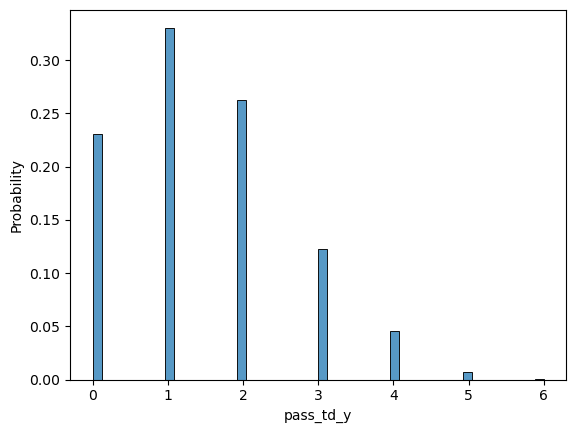

In [60]:
pass_td_y_mean = passes_pass_td_y['pass_td_y'].mean()

plot_pos = pd.DataFrame({
    "x":range(0,7),
    "expected": [poisson.pmf(x, passes_pass_td_y['pass_td_y'])for x in range(0,7)]})

sns.histplot(passes_pass_td_y["pass_td_y"], stat="probability")

ValueError: setting an array element with a sequence.

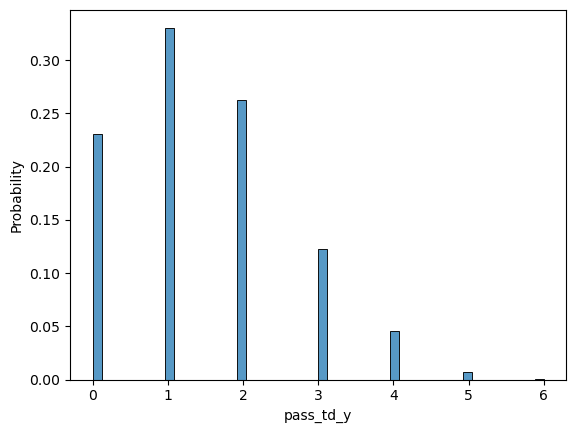

In [62]:

# Assuming pbp_py_pass_td_y is a DataFrame with a column "pass_td_y" that you want to plot as a histogram
sns.histplot(passes_pass_td_y["pass_td_y"], stat="probability")
plt.plot(plot_pos['x'], plot_pos['expected'], marker='o')  # Adding a marker for clarity
plt.show()